# Import package

In [1]:
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ridwanakmal","key":"d47613ff7b8c36d503860ad5aa867027"}'}

In [3]:
!mkdir -p ~/.kaggle                                               
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Load Data

In [4]:
!kaggle datasets download -d pranavraikokte/covid19-image-dataset

 99% 156M/158M [00:07<00:00, 24.5MB/s]
100% 158M/158M [00:07<00:00, 21.4MB/s]


In [ ]:
!unzip '/content/covid19-image-dataset.zip' -d '/content/cov19'

# Datagen

In [6]:
# ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

height, width = 224, 224
batch_size=64


def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

TRAINING_DIR = '/content/cov19/Covid19-dataset/test'
TESTING_DIR = '/content/cov19/Covid19-dataset/test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})

Found 66 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 40, 'Viral_Pneumonia_cases': 40, 'Covid_cases': 52}


# Images demonstration

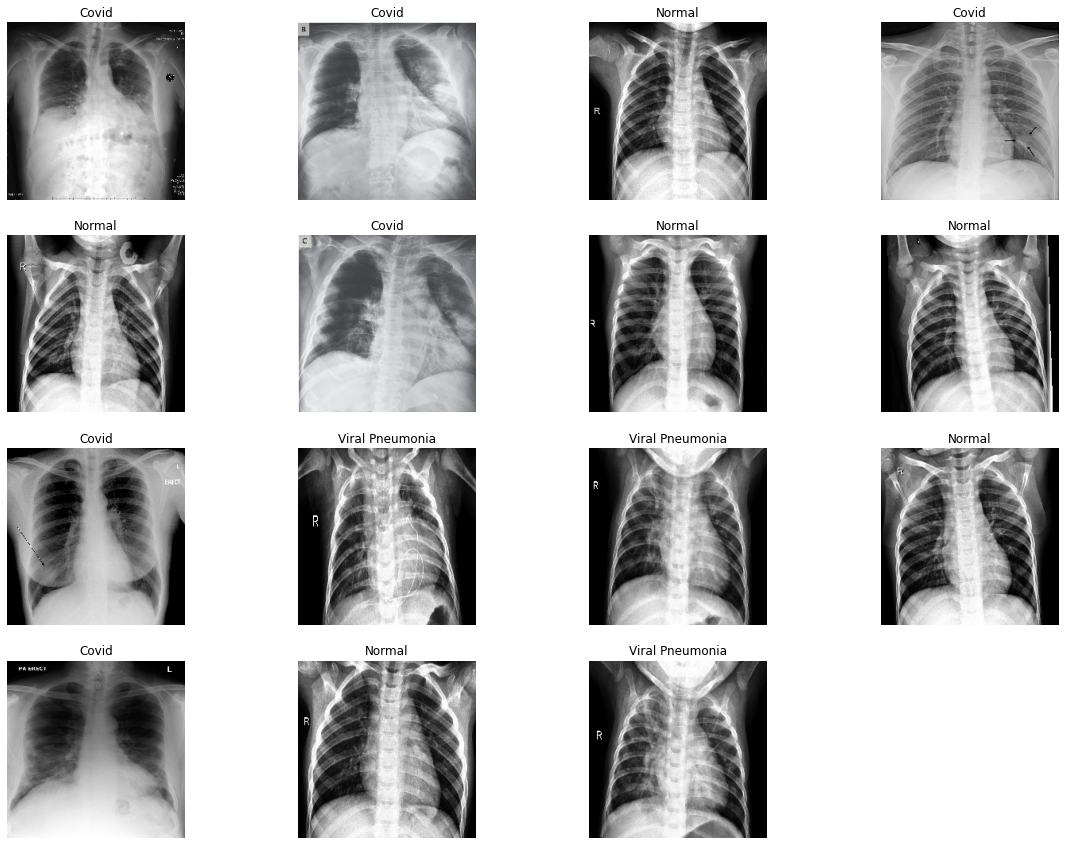

In [7]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Normal" if img_label[i] == 0 else "Viral Pneumonia" if img_label[i] == 1 else "Covid")
        plt.axis("off")

image_plot(train_generator,15)

<h3>Dense Net implementation</h3>

The reason that I added 2 more dense layers is to identify more clearly from the grayscale image.

The dropout layers are regularization for preventing overfitting.

In [18]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.densenet.DenseNet201(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

DenseNet_model = tf.keras.Sequential()
DenseNet_model.add(base_model)
DenseNet_model.add(tf.keras.layers.GlobalAveragePooling2D())

DenseNet_model.add(tf.keras.layers.Flatten())
DenseNet_model.add(tf.keras.layers.Dense(256, activation='relu'))
DenseNet_model.add(tf.keras.layers.Dropout(0.5))
DenseNet_model.add(tf.keras.layers.Dense(256, activation='relu'))
DenseNet_model.add(tf.keras.layers.Dropout(0.5))

DenseNet_model.add(tf.keras.layers.Dense(3, activation='softmax'))

DenseNet_model.compile(loss='SparseCategoricalCrossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
DenseNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 256)               491776    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

In [19]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/DenseNet_best.h10', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=10)

callbacks_list = [checkpoint,early]

history = DenseNet_model.fit(
        train_generator,
        validation_data = test_generator,
        epochs=50, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/50
1/2 [==============>...............] - ETA: 10s - loss: 1.5679 - acc: 0.2656
Epoch 1: acc improved from -inf to 0.25758, saving model to model/DenseNet_best.h10


2/2 [==============================] - 82s 72s/step - loss: 1.5557 - acc: 0.2576 - val_loss: 1.1959 - val_acc: 0.3939
Epoch 2/50
1/2 [==============>...............] - ETA: 1s - loss: 1.4068 - acc: 0.3906
Epoch 2: acc improved from 0.25758 to 0.39394, saving model to model/DenseNet_best.h10


2/2 [==============================] - 70s 68s/step - loss: 1.3855 - acc: 0.3939 - val_loss: 0.8010 - val_acc: 0.8182
Epoch 3/50
1/2 [==============>...............] - ETA: 1s - loss: 1.0324 - acc: 0.5312
Epoch 3: acc improved from 0.39394 to 0.51515, saving model to model/DenseNet_best.h10


2/2 [==============================] - 71s 69s/step - loss: 1.0895 - acc: 0.5152 - val_loss: 0.6928 - val_acc: 0.8030
Epoch 4/50
1/2 [==============>...............] - ETA: 1s - loss: 1.1284 - acc: 0.4219
Epoch 4: acc did not improve from 0.51515
2/2 [==============================] - 3s 2s/step - loss: 1.1083 - acc: 0.4394 - val_loss: 0.6192 - val_acc: 0.8182
Epoch 5/50
1/2 [==============>...............] - ETA: 1s - loss: 1.1717 - acc: 0.4688
Epoch 5: acc did not improve from 0.51515
2/2 [==============================] - 3s 2s/step - loss: 1.1514 - acc: 0.4697 - val_loss: 0.5357 - val_acc: 0.8485
Epoch 6/50
1/2 [==============>...............] - ETA: 1s - loss: 1.0086 - acc: 0.5625
Epoch 6: acc improved from 0.51515 to 0.57576, saving model to model/DenseNet_best.h10


2/2 [==============================] - 72s 70s/step - loss: 0.9868 - acc: 0.5758 - val_loss: 0.4869 - val_acc: 0.8636
Epoch 7/50
1/2 [==============>...............] - ETA: 1s - loss: 1.1164 - acc: 0.6094
Epoch 7: acc improved from 0.57576 to 0.62121, saving model to model/DenseNet_best.h10


2/2 [==============================] - 71s 70s/step - loss: 1.0861 - acc: 0.6212 - val_loss: 0.4959 - val_acc: 0.8788
Epoch 8/50
1/2 [==============>...............] - ETA: 1s - loss: 0.8682 - acc: 0.6719
Epoch 8: acc improved from 0.62121 to 0.68182, saving model to model/DenseNet_best.h10


2/2 [==============================] - 71s 70s/step - loss: 0.8480 - acc: 0.6818 - val_loss: 0.5428 - val_acc: 0.6970
Epoch 9/50
1/2 [==============>...............] - ETA: 1s - loss: 0.8970 - acc: 0.6719
Epoch 9: acc did not improve from 0.68182
2/2 [==============================] - 3s 2s/step - loss: 0.8745 - acc: 0.6818 - val_loss: 0.5238 - val_acc: 0.6970
Epoch 10/50
1/2 [==============>...............] - ETA: 1s - loss: 0.9280 - acc: 0.6562
Epoch 10: acc did not improve from 0.68182
2/2 [==============================] - 3s 2s/step - loss: 0.9009 - acc: 0.6667 - val_loss: 0.4053 - val_acc: 0.7879
Epoch 11/50
1/2 [==============>...............] - ETA: 1s - loss: 0.6969 - acc: 0.7031
Epoch 11: acc did not improve from 0.68182
2/2 [==============================] - 3s 2s/step - loss: 0.7095 - acc: 0.6818 - val_loss: 0.2867 - val_acc: 0.9545
Epoch 12/50
1/2 [==============>...............] - ETA: 1s - loss: 0.5142 - acc: 0.7812
Epoch 12: acc improved from 0.68182 to 0.78788, saving 

2/2 [==============================] - 71s 70s/step - loss: 0.5075 - acc: 0.7879 - val_loss: 0.3005 - val_acc: 0.9242
Epoch 13/50
1/2 [==============>...............] - ETA: 1s - loss: 0.5186 - acc: 0.7344
Epoch 13: acc did not improve from 0.78788
2/2 [==============================] - 3s 2s/step - loss: 0.5247 - acc: 0.7273 - val_loss: 0.3265 - val_acc: 0.9242
Epoch 14/50
1/2 [==============>...............] - ETA: 1s - loss: 0.8251 - acc: 0.5625
Epoch 14: acc did not improve from 0.78788
2/2 [==============================] - 3s 2s/step - loss: 0.8746 - acc: 0.5455 - val_loss: 0.3037 - val_acc: 0.9242
Epoch 15/50
1/2 [==============>...............] - ETA: 1s - loss: 0.9665 - acc: 0.6406
Epoch 15: acc did not improve from 0.78788
2/2 [==============================] - 3s 2s/step - loss: 0.9516 - acc: 0.6515 - val_loss: 0.2622 - val_acc: 0.9091
Epoch 16/50
1/2 [==============>...............] - ETA: 1s - loss: 0.5967 - acc: 0.7344
Epoch 16: acc did not improve from 0.78788
2/2 [=====

2/2 [==============================] - 71s 69s/step - loss: 0.3984 - acc: 0.8485 - val_loss: 0.3086 - val_acc: 0.9242
Epoch 18/50
1/2 [==============>...............] - ETA: 1s - loss: 0.6674 - acc: 0.7656
Epoch 18: acc did not improve from 0.84848
2/2 [==============================] - 3s 2s/step - loss: 0.6899 - acc: 0.7576 - val_loss: 0.3464 - val_acc: 0.8636
Epoch 19/50
1/2 [==============>...............] - ETA: 1s - loss: 0.6057 - acc: 0.7656
Epoch 19: acc did not improve from 0.84848
2/2 [==============================] - 3s 2s/step - loss: 0.6164 - acc: 0.7576 - val_loss: 0.4355 - val_acc: 0.7273
Epoch 20/50
1/2 [==============>...............] - ETA: 1s - loss: 0.6081 - acc: 0.7500
Epoch 20: acc did not improve from 0.84848
2/2 [==============================] - 3s 2s/step - loss: 0.6049 - acc: 0.7424 - val_loss: 0.6084 - val_acc: 0.6970
Epoch 21/50
1/2 [==============>...............] - ETA: 1s - loss: 0.6976 - acc: 0.6719
Epoch 21: acc did not improve from 0.84848
2/2 [=====

2/2 [==============================] - 70s 69s/step - loss: 0.2726 - acc: 0.9394 - val_loss: 0.1383 - val_acc: 0.9697
Epoch 32/50
1/2 [==============>...............] - ETA: 1s - loss: 0.3777 - acc: 0.8281
Epoch 32: acc did not improve from 0.93939
2/2 [==============================] - 3s 2s/step - loss: 0.3818 - acc: 0.8182 - val_loss: 0.1215 - val_acc: 0.9848
Epoch 33/50
1/2 [==============>...............] - ETA: 1s - loss: 0.3252 - acc: 0.8750
Epoch 33: acc did not improve from 0.93939
2/2 [==============================] - 3s 2s/step - loss: 0.3156 - acc: 0.8788 - val_loss: 0.1238 - val_acc: 0.9697
Epoch 34/50
1/2 [==============>...............] - ETA: 1s - loss: 0.4497 - acc: 0.8125
Epoch 34: acc did not improve from 0.93939
2/2 [==============================] - 3s 2s/step - loss: 0.4616 - acc: 0.8030 - val_loss: 0.1311 - val_acc: 0.9697
Epoch 35/50
1/2 [==============>...............] - ETA: 1s - loss: 0.2133 - acc: 0.9062
Epoch 35: acc did not improve from 0.93939
2/2 [=====

2/2 [==============================] - 70s 69s/step - loss: 0.1284 - acc: 0.9697 - val_loss: 0.0444 - val_acc: 1.0000
Epoch 50/50
1/2 [==============>...............] - ETA: 1s - loss: 0.2093 - acc: 0.8750
Epoch 50: acc did not improve from 0.96970
2/2 [==============================] - 3s 2s/step - loss: 0.2031 - acc: 0.8788 - val_loss: 0.0416 - val_acc: 1.0000


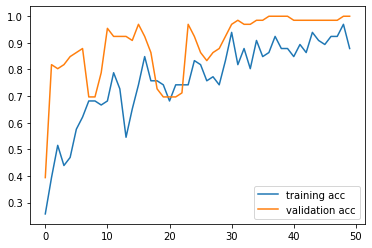

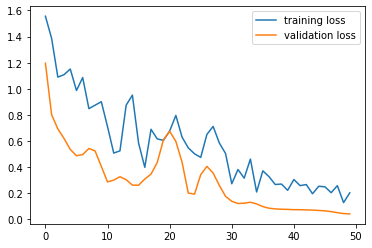

In [20]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history)

In [21]:
train_result = DenseNet_model.evaluate(train_generator)
test_result = DenseNet_model.evaluate(test_generator)

score_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
score_df

2/2 [==============================] - 2s 34ms/step - loss: 0.0416 - acc: 1.0000


,Train,Val
Loss,0.041628,0.041628
Acc,1.000000,1.000000


3/3 [==============================] - 3s 159ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       1.00      1.00      1.00        20
         2.0       1.00      1.00      1.00        26

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66



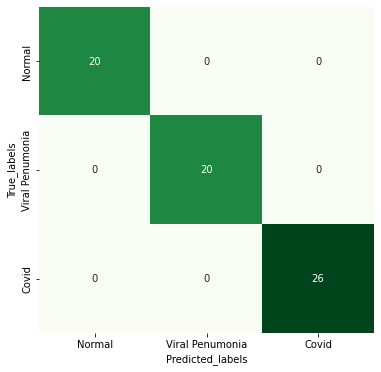

In [22]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob = DenseNet_model.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Greens', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))